# **Transformations for Numerical Variables**

## Objectives

* To test various transformers on the numerical variables to see which one is best i.e. results in a distribution closest to normal. This will be used for ML 

## Inputs

* The csv file "US_Accidents_For_ML", which is saved locally in "Data/ML" 

## Outputs

* Understanding of which transformers to use during model selection

## Summary of Steps

* Load the dataset
* See which variables have zero or negative values
* Try compatible transformers with variables without zero or negative values, pick best transformer per variable
* Try compatible transformers with variables with zero or negative values, pick best transformer per variable

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Accidents_ML_Project\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Accidents_ML_Project'

---

## Required Libraries

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import skew, kurtosis
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer, PowerTransformer
from sklearn.preprocessing import QuantileTransformer, RobustScaler, MinMaxScaler

---

## Load the Dataset

I will load the dataset using Pandas.

In [5]:
df = pd.read_csv("Data/ML/US_Accidents_For_ML.csv")
pd.set_option("display.max_columns", None)
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Clearance_Class,Weather_Simplified,State_Other,Road_Type,Population,County_Other,Month
0,2,32.456486,-93.774536,0.501,Central,78.0,62.0,29.61,10.0,CALM,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Night,Very Long,Fair,LA,Avenue,187540,Caddo,Sep
1,2,36.804693,-76.189728,0.253,Eastern,54.0,90.0,30.40,7.0,CALM,0.0,0.0,False,False,True,False,False,False,False,False,False,False,True,Night,Very Long,Fair,VA,Drive,459444,Virginia Beach,May
2,2,29.895741,-90.090026,1.154,Pacific,40.0,58.0,30.28,10.0,N,10.0,0.0,False,False,False,False,True,False,False,False,False,False,False,Day,Very Long,Cloudy,LA,Drive,440784,Jefferson,Jan
3,2,32.456459,-93.779709,0.016,Central,62.0,75.0,29.80,10.0,SSE,8.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Night,Very Long,Cloudy,LA,Avenue,187540,Caddo,Nov
4,2,26.966433,-82.255414,0.057,Eastern,84.0,69.0,29.99,10.0,E,18.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Day,Very Long,Cloudy,FL,Boulevard,186824,Charlotte,Sep


---

## Selection of Variables and Transformers

I intend to transform all numeric varaibles except "Start_Lat" and "Start_Lng". Some transformers can only handle numbers > 0, therefore I am checking which of these variables do not meet this condition.

In [6]:
# Select only numeric columns
num_cols = ["Distance(mi)", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", 
            "Wind_Speed(mph)", "Precipitation(in)", "Population"]

# Find columns that contain any negative values
zero_negative_summary = (
    (df[num_cols] <= 0)
    .sum()
    .reset_index()
    .rename(columns={"index": "Column", 0: "Negative_Count"})
)

# Keep only those columns that actually have negatives
zero_negative_summary = zero_negative_summary[zero_negative_summary["Negative_Count"] > 0]

# Display summary
if zero_negative_summary.empty:
    print("No zero or negative values found in numeric columns.")
else:
    print("Columns containing zero or negative values:")
    display(zero_negative_summary)

Columns containing zero or negative values:


,Column,Negative_Count
0,Distance(mi),2360
1,Temperature(F),23
4,Visibility(mi),15
5,Wind_Speed(mph),1769
6,Precipitation(in),9192


"Distance(mi)", "Temperature(F)", "Visibility(mi)", "Wind_Speed(mph)" and "Precipitation(in)" all have zero and/ or negative values. I will deal with these variables seperately to the rest.

---

## Transformation of Variable without Zero or Negative Values

For variables without zero or negative numbers I will be trying the Log Transformer, the Yeo Johnson Transformer, and the PowerTransformer from Feature Engine.

The code blow calculates skew and kurtosis, and plots the histogram and QQ plot for each variable.

In [7]:
def calculate_skew_kurtosis(df, col, moment):
    skewness = df[col].skew()
    kurt = df[col].kurt()
    print(f"{moment} — {col}: skew = {skewness:.3f}, kurtosis = {kurt:.3f}")

def compare_distributions_before_and_after_applying_transformer(df, df_transformed, method):
    for col in df.columns:
        print(f"*** {col} ***")
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,5))

        sns.histplot(data=df, x=col, kde=True, ax=axes[0,0])
        axes[0,0].set_title(f'Before {method}')
        pg.qqplot(df[col], dist='norm', ax=axes[0,1])

        sns.histplot(data=df_transformed, x=col, kde=True, ax=axes[1,0])
        axes[1,0].set_title(f'After {method}')
        pg.qqplot(df_transformed[col], dist='norm', ax=axes[1,1])

        plt.tight_layout()
        plt.show()

        calculate_skew_kurtosis(df, col, 'before transformation')
        calculate_skew_kurtosis(df_transformed, col, 'after transformation')
        print("\n")

The code below collects and appends the summary measurements of skew and kurtosis, before and after transformations, and also calculates absolute change in skew and kurtosis.

In [8]:
## assistance from AI taken ##

def collect_summary_stats(df_before, df_after, transformer_name, summary_list):
    for col in df_before.columns:
        if not pd.api.types.is_numeric_dtype(df_before[col]):
            continue  # skip non-numeric
        try:
            skew_before = skew(df_before[col].dropna())
            kurt_before = kurtosis(df_before[col].dropna())
            skew_after = skew(df_after[col].dropna())
            kurt_after = kurtosis(df_after[col].dropna())

            summary_list.append({
                "Variable": col,
                "Transformer": transformer_name,
                "Skew_before": skew_before,
                "Skew_after": skew_after,
                "Δ|Skew|": abs(abs(skew_before) - abs(skew_after)),
                "Kurtosis_before": kurt_before,
                "Kurtosis_after": kurt_after,
                "Δ|Kurtosis|": abs(abs(kurt_before) - abs(kurt_after))
            })
        except Exception as e:
            print(f"Could not compute stats for {col}: {e}")

The code below gives the columns to process, calls the functions created above, applied each transformation to one varaible before moving on to the next, and then at the end, outputs a summary DataFrame of skew and kurtosis measurements. 


===== Variable: Humidity(%) =====
--- Applying LogTransformer ---
*** Humidity(%) ***


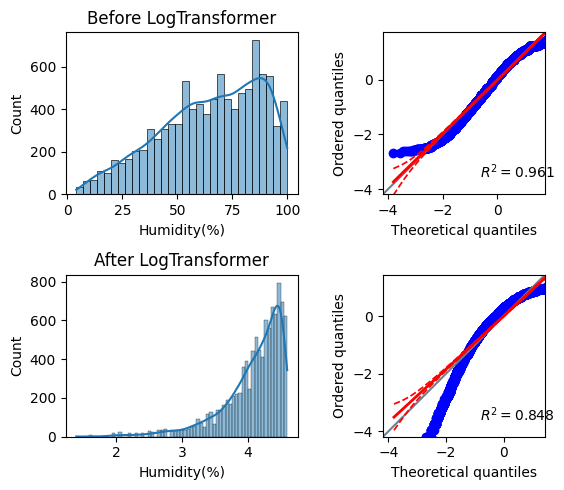

before transformation — Humidity(%): skew = -0.468, kurtosis = -0.640
after transformation — Humidity(%): skew = -1.678, kurtosis = 3.473


--- Applying YeoJohnsonTransformer ---
*** Humidity(%) ***


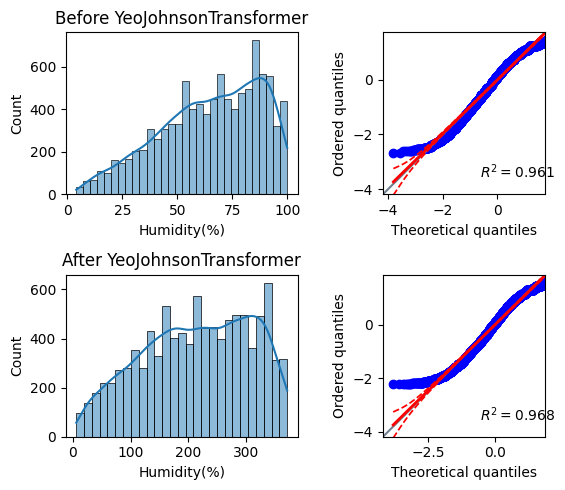

before transformation — Humidity(%): skew = -0.468, kurtosis = -0.640
after transformation — Humidity(%): skew = -0.231, kurtosis = -0.946


--- Applying PowerTransformer ---
*** Humidity(%) ***


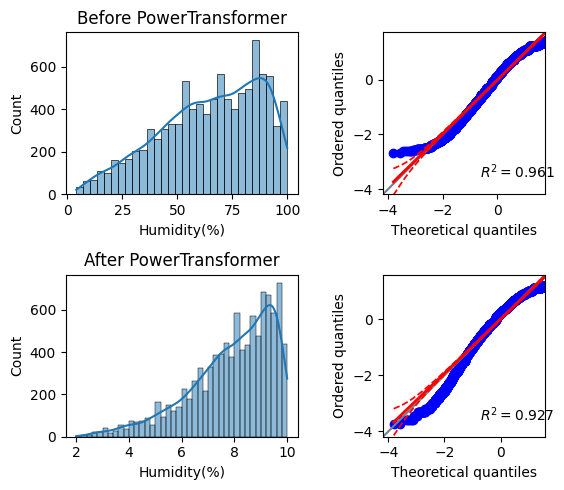

before transformation — Humidity(%): skew = -0.468, kurtosis = -0.640
after transformation — Humidity(%): skew = -0.939, kurtosis = 0.449



===== Variable: Pressure(in) =====
--- Applying LogTransformer ---
*** Pressure(in) ***


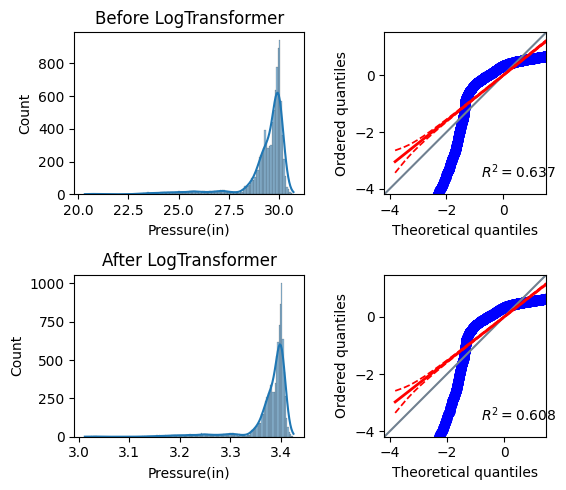

before transformation — Pressure(in): skew = -2.957, kurtosis = 9.839
after transformation — Pressure(in): skew = -3.197, kurtosis = 11.931


--- Applying YeoJohnsonTransformer ---
*** Pressure(in) ***


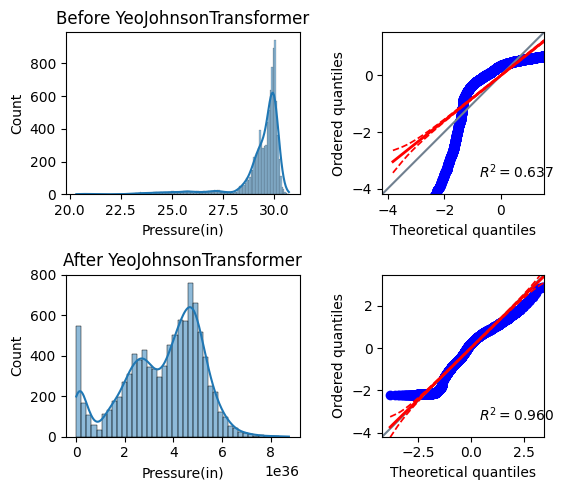

before transformation — Pressure(in): skew = -2.957, kurtosis = 9.839
after transformation — Pressure(in): skew = -0.509, kurtosis = -0.366


--- Applying PowerTransformer ---
*** Pressure(in) ***


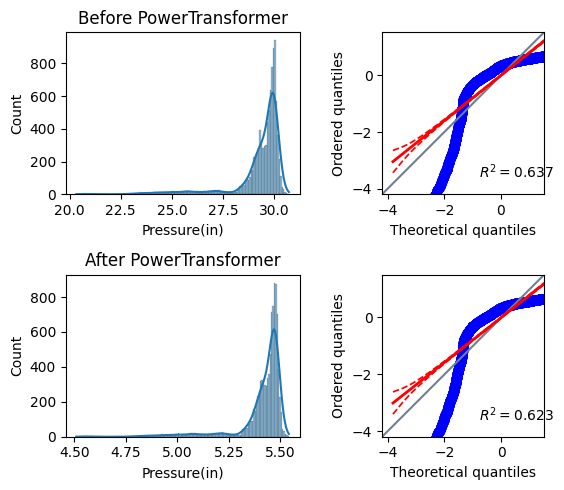

before transformation — Pressure(in): skew = -2.957, kurtosis = 9.839
after transformation — Pressure(in): skew = -3.072, kurtosis = 10.809



===== Variable: Population =====
--- Applying LogTransformer ---
*** Population ***


c:\Users\sonia\Documents\VS Studio Projects\US_Accidents_ML_Project\.venv\Lib\site-packages\feature_engine\transformation\log.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.14174743 13.03777234 12.99631024 ... 10.27059291 11.13654332
 14.69323675]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log(X.loc[:, self.variables_])


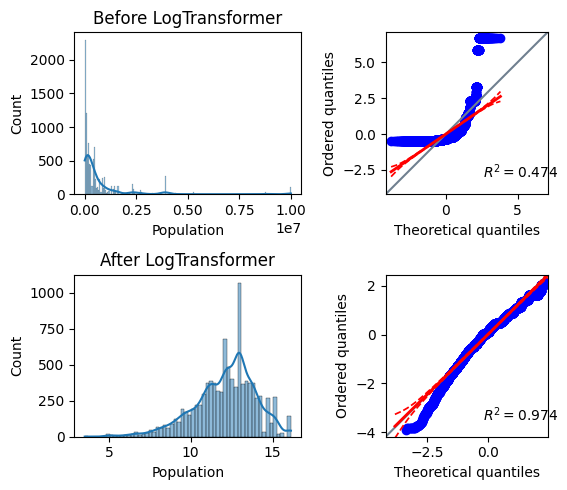

before transformation — Population: skew = 4.553, kurtosis = 24.731
after transformation — Population: skew = -0.665, kurtosis = 0.737


--- Applying YeoJohnsonTransformer ---
*** Population ***


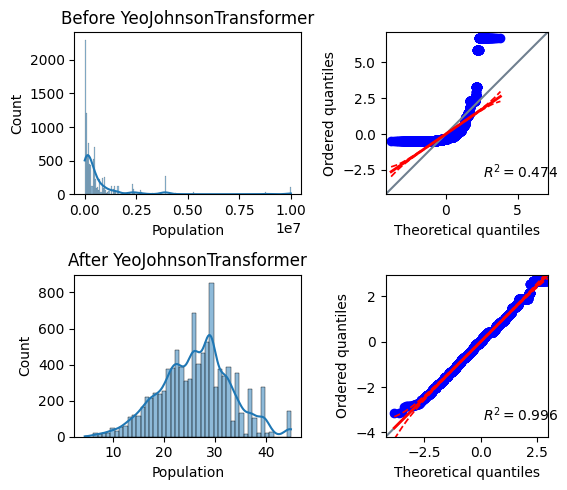

before transformation — Population: skew = 4.553, kurtosis = 24.731
after transformation — Population: skew = -0.003, kurtosis = 0.003


--- Applying PowerTransformer ---
*** Population ***


c:\Users\sonia\Documents\VS Studio Projects\US_Accidents_ML_Project\.venv\Lib\site-packages\feature_engine\transformation\power.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 433.05888745  677.82298574  663.91565729 ...  169.91468447  261.98091534
 1550.94293899]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.power(X.loc[:, self.variables_], self.exp)


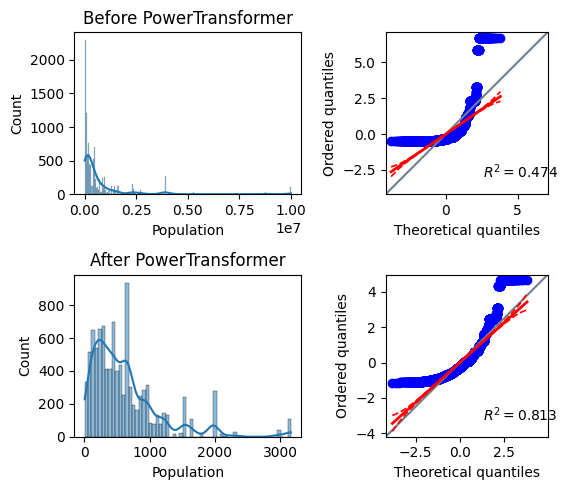

before transformation — Population: skew = 4.553, kurtosis = 24.731
after transformation — Population: skew = 2.032, kurtosis = 5.496




,Variable,Transformer,Skew_before,Skew_after,Δ|Skew|,Kurtosis_before,Kurtosis_after,Δ|Kurtosis|
0,Humidity(%),LogTransformer,-0.47,-1.68,1.21,-0.64,3.47,2.83
1,Humidity(%),PowerTransformer,-0.47,-0.94,0.47,-0.64,0.45,0.19
2,Humidity(%),YeoJohnsonTransformer,-0.47,-0.23,0.24,-0.64,-0.95,0.31
3,Population,YeoJohnsonTransformer,4.55,-0.00,4.55,24.72,0.00,24.72
4,Population,LogTransformer,4.55,-0.66,3.89,24.72,0.74,23.98
5,Population,PowerTransformer,4.55,2.03,2.52,24.72,5.49,19.22
6,Pressure(in),YeoJohnsonTransformer,-2.96,-0.51,2.45,9.83,-0.37,9.47
7,Pressure(in),LogTransformer,-2.96,-3.20,0.24,9.83,11.92,2.09
8,Pressure(in),PowerTransformer,-2.96,-3.07,0.12,9.83,10.80,0.97


In [15]:
# Columns to loop over (numeric variables)
num_cols = ["Humidity(%)", "Pressure(in)", "Population"]

# Define transformers
transformers = {
    "LogTransformer": lambda var: LogTransformer(variables=[var]),
    "YeoJohnsonTransformer": lambda var: YeoJohnsonTransformer(variables=[var]),
    "PowerTransformer": lambda var: PowerTransformer(variables=[var]),
}

summary = []

# Loop through each variable first
for var in num_cols:
    print(f"\n===== Variable: {var} =====")
    for name, transformer_func in transformers.items():
        print(f"--- Applying {name} ---")
        try:
            transformer = transformer_func(var)
            
            # Fit and transform
            df_transformed = transformer.fit_transform(df[[var]])
            
            # Plot before & after
            compare_distributions_before_and_after_applying_transformer(df[[var]], df_transformed, name)
            
            # Collect stats
            collect_summary_stats(df[[var]], df_transformed, transformer_name=name, summary_list=summary)
        
        except Exception as e:
            print(f"{name} failed for {var}: {e}")

# Create summary table
summary_df = (
    pd.DataFrame(summary)
    .sort_values(by=["Variable", "Δ|Skew|"], ascending=[True, False])
    .reset_index(drop=True)
)

numeric_cols = ["Skew_before", "Skew_after", "Δ|Skew|", "Kurtosis_before", "Kurtosis_after", "Δ|Kurtosis|"]

summary_df[numeric_cols] = summary_df[numeric_cols].apply(lambda x: x.round(2))

display(summary_df)

For each of the 3 variables, I will be using the Yeo Johnson transformer, as it gives the best performance of bringing the distrubtions closest to normal.

---

## Transformation of Variable with Zero or Negative Values

For variables with zero and/ or netagive values, I will be trying the Yeo Johnson Transformer from Feature Engine again, together with Quantile Transformer, RobustScaler and MinMaxScaler from Scikit Learn. 


===== Variable: Distance(mi) =====
--- Applying YeoJohnsonTransformer ---
*** Distance(mi) ***


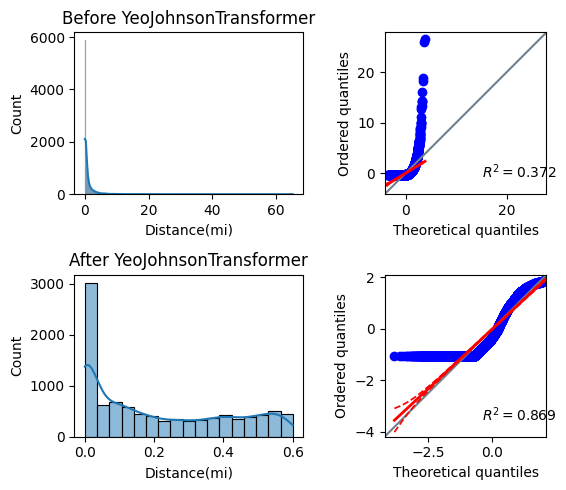

before transformation — Distance(mi): skew = 9.587, kurtosis = 161.984
after transformation — Distance(mi): skew = 0.513, kurtosis = -1.202


--- Applying QuantileTransformer ---
*** Distance(mi) ***


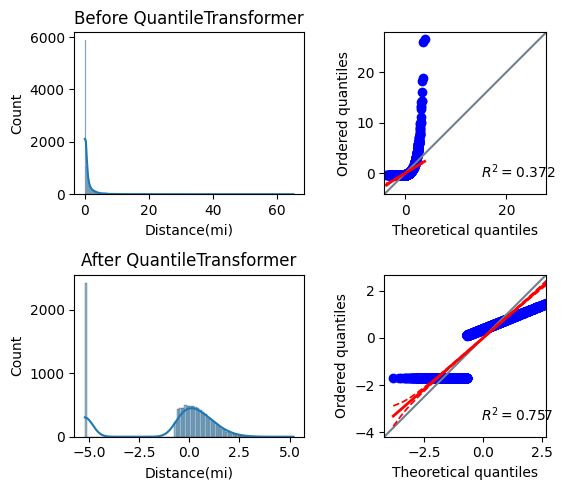

before transformation — Distance(mi): skew = 9.587, kurtosis = 161.984
after transformation — Distance(mi): skew = -0.957, kurtosis = -0.710


--- Applying RobustScaler ---
*** Distance(mi) ***


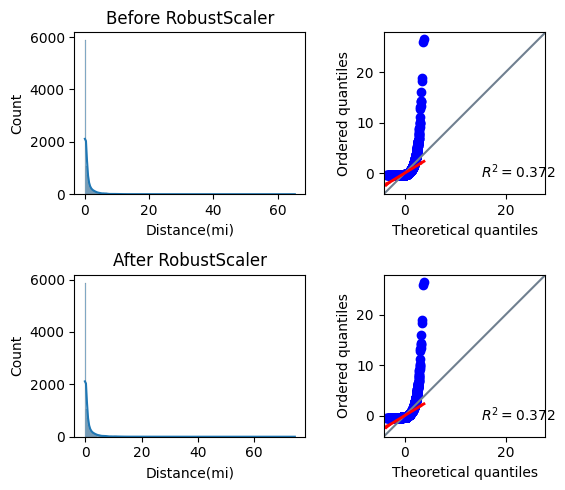

before transformation — Distance(mi): skew = 9.587, kurtosis = 161.984
after transformation — Distance(mi): skew = 9.587, kurtosis = 161.984


--- Applying MinMaxScaler ---
*** Distance(mi) ***


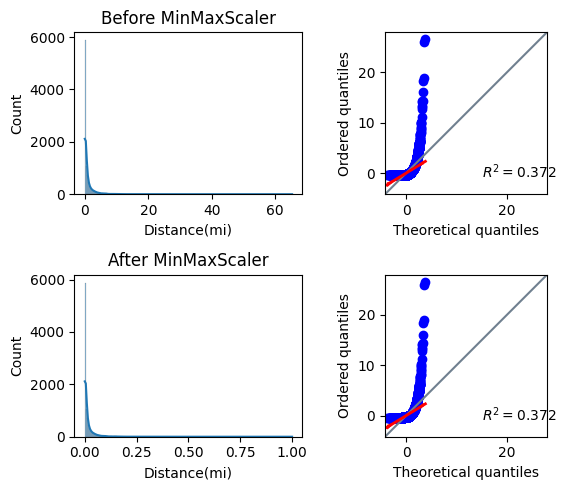

before transformation — Distance(mi): skew = 9.587, kurtosis = 161.984
after transformation — Distance(mi): skew = 9.587, kurtosis = 161.984



===== Variable: Visibility(mi) =====
--- Applying YeoJohnsonTransformer ---
*** Visibility(mi) ***


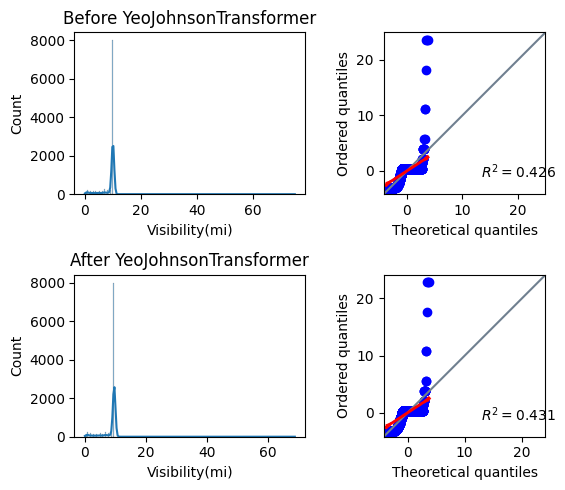

before transformation — Visibility(mi): skew = 3.355, kurtosis = 110.138
after transformation — Visibility(mi): skew = 2.831, kurtosis = 96.592


--- Applying QuantileTransformer ---
*** Visibility(mi) ***


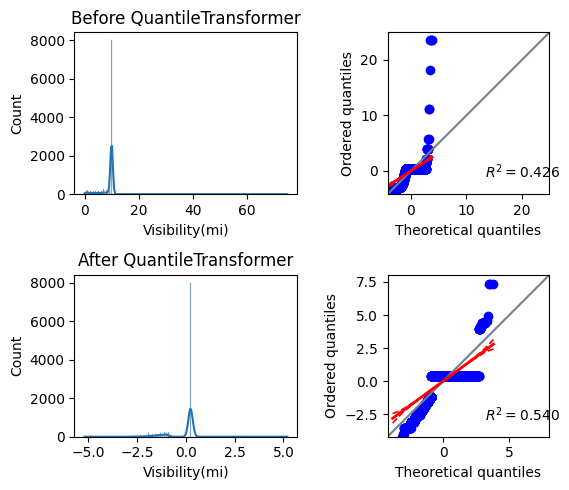

before transformation — Visibility(mi): skew = 3.355, kurtosis = 110.138
after transformation — Visibility(mi): skew = -1.600, kurtosis = 5.613


--- Applying RobustScaler ---
*** Visibility(mi) ***


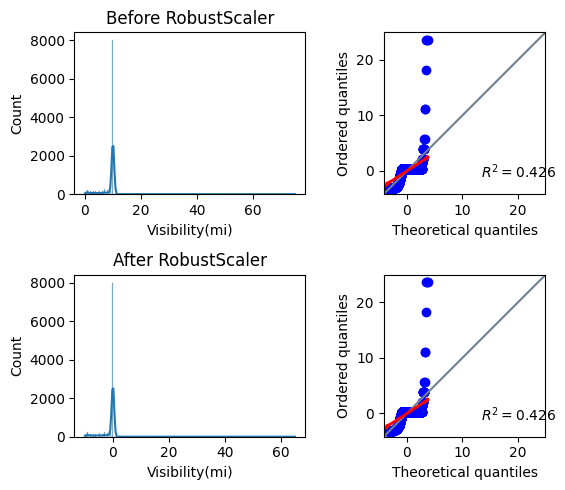

before transformation — Visibility(mi): skew = 3.355, kurtosis = 110.138
after transformation — Visibility(mi): skew = 3.355, kurtosis = 110.138


--- Applying MinMaxScaler ---
*** Visibility(mi) ***


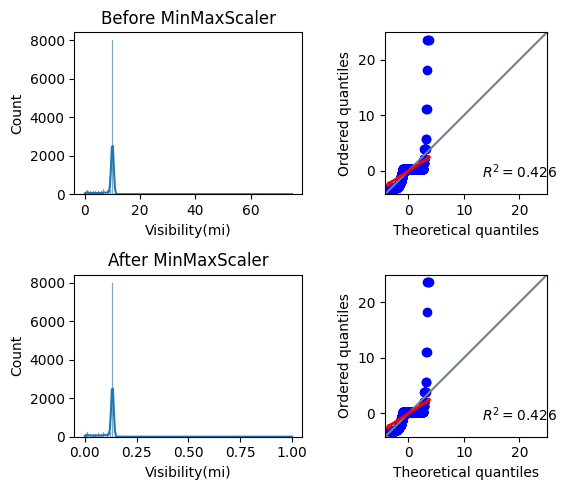

before transformation — Visibility(mi): skew = 3.355, kurtosis = 110.138
after transformation — Visibility(mi): skew = 3.355, kurtosis = 110.138



===== Variable: Temperature(F) =====
--- Applying YeoJohnsonTransformer ---
*** Temperature(F) ***


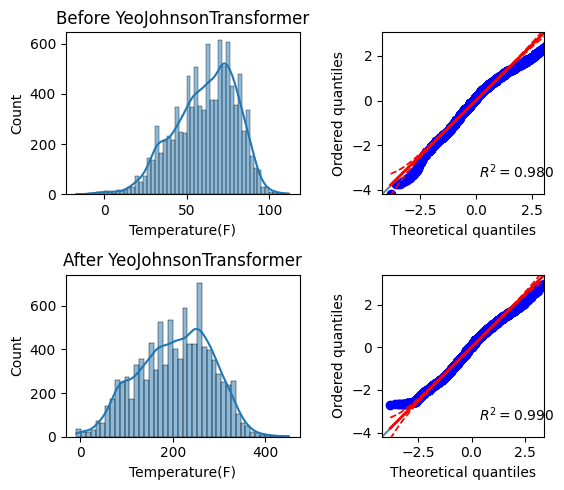

before transformation — Temperature(F): skew = -0.484, kurtosis = -0.117
after transformation — Temperature(F): skew = -0.178, kurtosis = -0.582


--- Applying QuantileTransformer ---
*** Temperature(F) ***


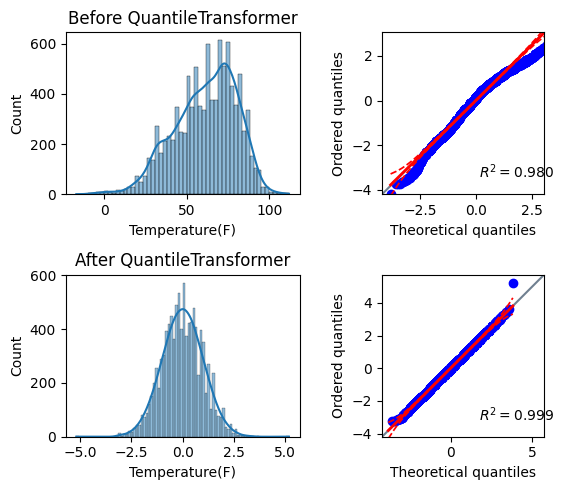

before transformation — Temperature(F): skew = -0.484, kurtosis = -0.117
after transformation — Temperature(F): skew = 0.002, kurtosis = 0.073


--- Applying RobustScaler ---
*** Temperature(F) ***


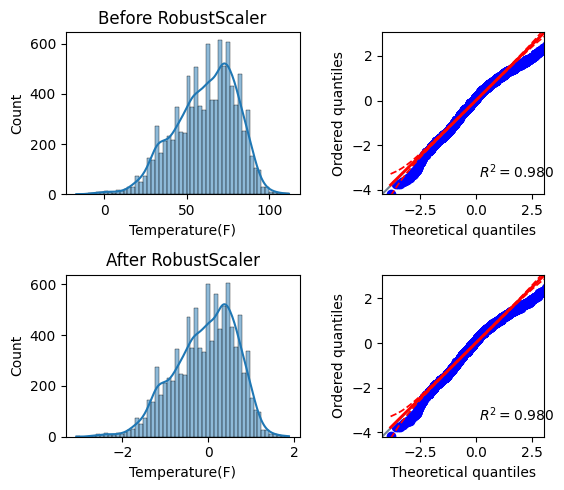

before transformation — Temperature(F): skew = -0.484, kurtosis = -0.117
after transformation — Temperature(F): skew = -0.484, kurtosis = -0.117


--- Applying MinMaxScaler ---
*** Temperature(F) ***


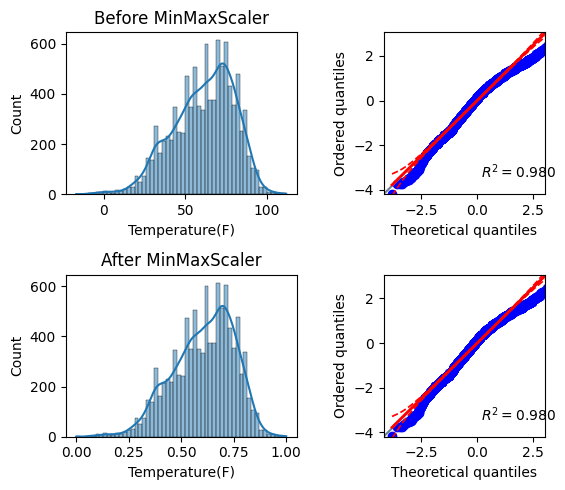

before transformation — Temperature(F): skew = -0.484, kurtosis = -0.117
after transformation — Temperature(F): skew = -0.484, kurtosis = -0.117



===== Variable: Wind_Speed(mph) =====
--- Applying YeoJohnsonTransformer ---
*** Wind_Speed(mph) ***


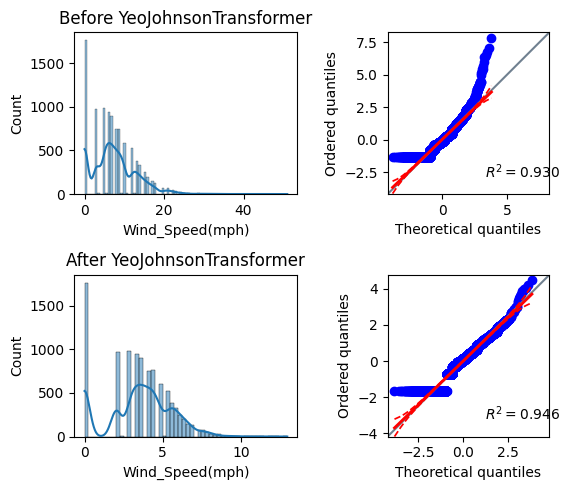

before transformation — Wind_Speed(mph): skew = 0.941, kurtosis = 2.244
after transformation — Wind_Speed(mph): skew = -0.116, kurtosis = -0.302


--- Applying QuantileTransformer ---
*** Wind_Speed(mph) ***


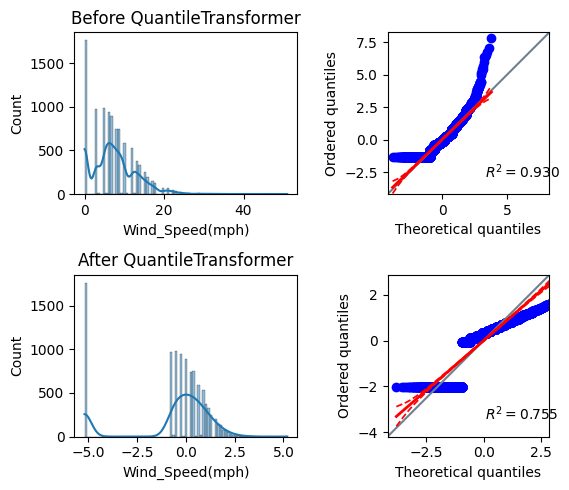

before transformation — Wind_Speed(mph): skew = 0.941, kurtosis = 2.244
after transformation — Wind_Speed(mph): skew = -1.286, kurtosis = 0.318


--- Applying RobustScaler ---
*** Wind_Speed(mph) ***


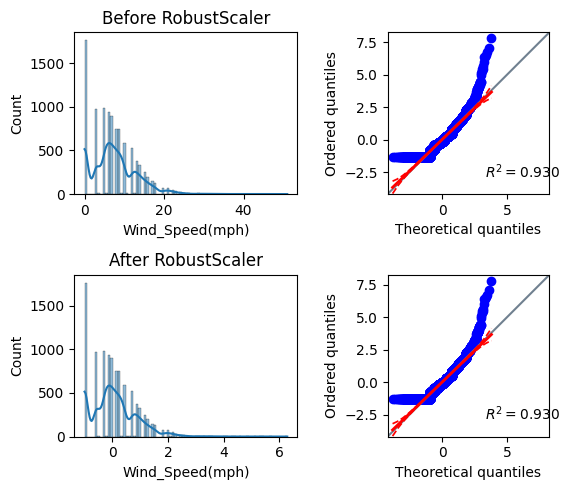

before transformation — Wind_Speed(mph): skew = 0.941, kurtosis = 2.244
after transformation — Wind_Speed(mph): skew = 0.941, kurtosis = 2.244


--- Applying MinMaxScaler ---
*** Wind_Speed(mph) ***


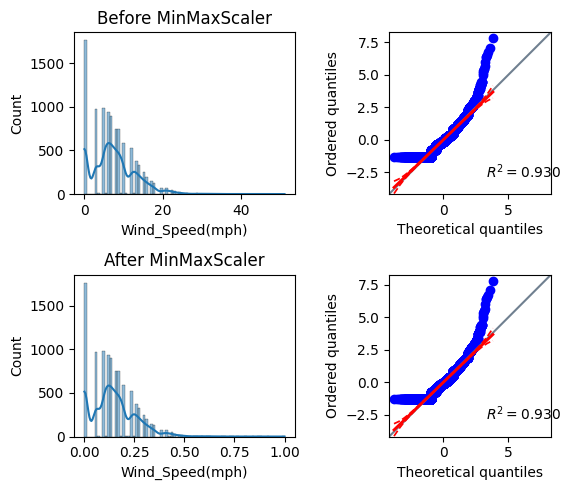

before transformation — Wind_Speed(mph): skew = 0.941, kurtosis = 2.244
after transformation — Wind_Speed(mph): skew = 0.941, kurtosis = 2.244



===== Variable: Precipitation(in) =====
--- Applying YeoJohnsonTransformer ---
*** Precipitation(in) ***


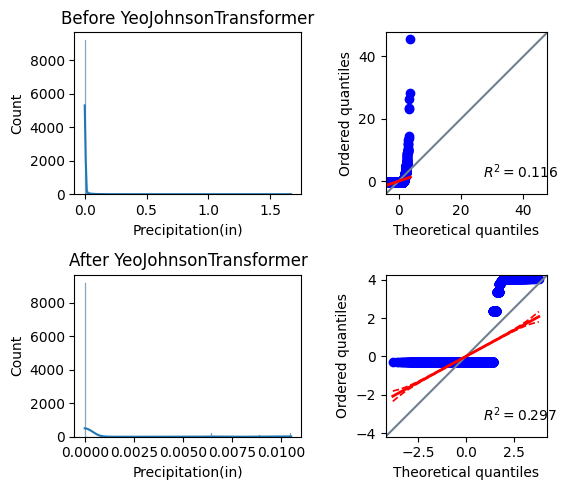

before transformation — Precipitation(in): skew = 19.880, kurtosis = 631.723
after transformation — Precipitation(in): skew = 3.389, kurtosis = 9.839


--- Applying QuantileTransformer ---
*** Precipitation(in) ***


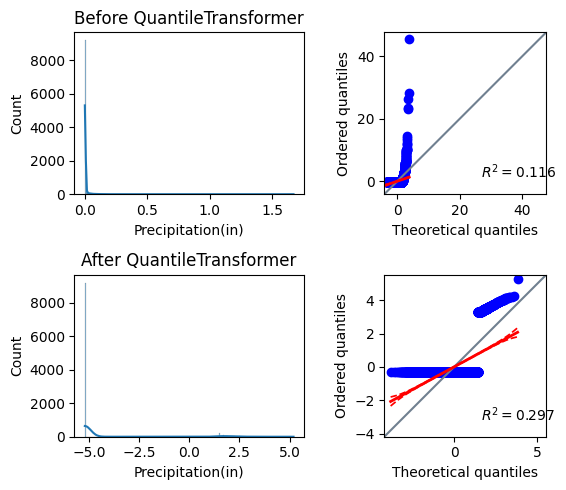

before transformation — Precipitation(in): skew = 19.880, kurtosis = 631.723
after transformation — Precipitation(in): skew = 3.221, kurtosis = 8.435


--- Applying RobustScaler ---
*** Precipitation(in) ***


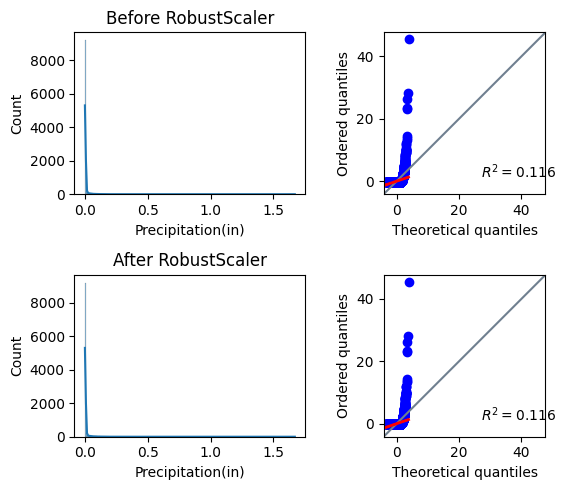

before transformation — Precipitation(in): skew = 19.880, kurtosis = 631.723
after transformation — Precipitation(in): skew = 19.880, kurtosis = 631.723


--- Applying MinMaxScaler ---
*** Precipitation(in) ***


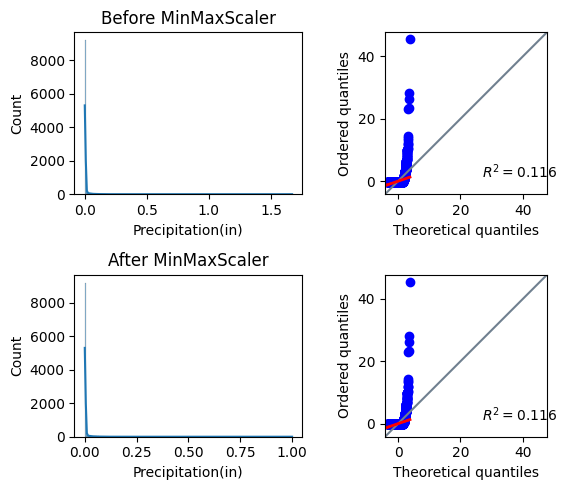

before transformation — Precipitation(in): skew = 19.880, kurtosis = 631.723
after transformation — Precipitation(in): skew = 19.880, kurtosis = 631.723




,Variable,Transformer,Skew_before,Skew_after,Δ|Skew|,Kurtosis_before,Kurtosis_after,Δ|Kurtosis|
0,Distance(mi),YeoJohnsonTransformer,9.59,0.51,9.07,161.90,-1.20,160.70
1,Distance(mi),QuantileTransformer,9.59,-0.96,8.63,161.90,-0.71,161.19
2,Distance(mi),MinMaxScaler,9.59,9.59,0.00,161.90,161.90,0.00
3,Distance(mi),RobustScaler,9.59,9.59,0.00,161.90,161.90,0.00
4,Precipitation(in),QuantileTransformer,19.88,3.22,16.66,631.41,8.43,622.98
5,Precipitation(in),YeoJohnsonTransformer,19.88,3.39,16.49,631.41,9.83,621.57
6,Precipitation(in),MinMaxScaler,19.88,19.88,0.00,631.41,631.41,0.00
7,Precipitation(in),RobustScaler,19.88,19.88,0.00,631.41,631.41,0.00
8,Temperature(F),QuantileTransformer,-0.48,0.00,0.48,-0.12,0.07,0.05
9,Temperature(F),YeoJohnsonTransformer,-0.48,-0.18,0.31,-0.12,-0.58,0.46


In [17]:
# Columns to loop over (those with zero/negative)
num_cols_neg_zero = ["Distance(mi)", "Visibility(mi)", "Temperature(F)", "Wind_Speed(mph)", "Precipitation(in)"]

# Define transformers safe for zero/negative numbers
transformers_neg_zero = {
    "YeoJohnsonTransformer": lambda var: YeoJohnsonTransformer(variables=[var]),
    "QuantileTransformer": lambda var: QuantileTransformer(output_distribution='normal'),
    "RobustScaler": lambda var: RobustScaler(),
    "MinMaxScaler": lambda var: MinMaxScaler(),
}

summary = []

# Loop through each variable first
for var in num_cols_neg_zero:
    print(f"\n===== Variable: {var} =====")
    for name, transformer_func in transformers_neg_zero.items():
        print(f"--- Applying {name} ---")
        try:
            transformer = transformer_func(var)
            
            # Fit and transform
            if name in ["QuantileTransformer", "RobustScaler", "MinMaxScaler"]:
                df_transformed = pd.DataFrame(transformer.fit_transform(df[[var]]), columns=[var])
            else:
                df_transformed = transformer.fit_transform(df[[var]])
            
            # Plot before & after
            compare_distributions_before_and_after_applying_transformer(df[[var]], df_transformed, name)
            
            # Collect stats
            collect_summary_stats(df[[var]], df_transformed, transformer_name=name, summary_list=summary)
        
        except Exception as e:
            print(f"{name} failed for {var}: {e}")

# Create summary table
summary_df = (
    pd.DataFrame(summary)
    .sort_values(by=["Variable", "Δ|Skew|"], ascending=[True, False])
    .reset_index(drop=True)
)

numeric_cols = ["Skew_before", "Skew_after", "Δ|Skew|", "Kurtosis_before", "Kurtosis_after", "Δ|Kurtosis|"]

summary_df[numeric_cols] = summary_df[numeric_cols].apply(lambda x: x.round(2))

display(summary_df)

I will be using the YJ Transformer for "Distance(mi)" and "Wind_Speed(mph), and using the Quantile Transformer for "Precipitation(in)", "Temperature(F)" and "Visibility(mi).

---

## Conclusions and Next Steps

* I have ascertained to use the YJ transformer for: "Distance(mi)", "Humidity(%)", "Population", "Pressure(in)" and "Wind_Speed(mph)
* I have ascertained to use the Quantile transformer for: "Temperature(F)", "Visibility(mi)" and "Precipitation(in)"
* The next step is to look at ML algorithms in the notebook "ML_Optimisation"